In [1]:
import pandas as pd
import re
from datetime import datetime

file_path = '/content/drive/My Drive/ChanTest.csv'

try:
    df = pd.read_csv(file_path, on_bad_lines='skip', delimiter=',', quotechar='"', escapechar='\\')
    print(f"Number of rows in the dataset: {df.shape[0]}")
except Exception as e:
    print(f"Error reading the file: {e}")
    raise

def extract_value(row, key):
    pattern = f'"{key}\'?":\\s?(\\d+)'
    for col in row.index:
        if pd.notnull(row[col]):
            match = re.search(pattern, str(row[col]))
            if match:
                return match.group(1)
    return None

df['tim'] = df.apply(lambda row: extract_value(row, 'tim'), axis=1)
df['time'] = df.apply(lambda row: extract_value(row, 'time'), axis=1)

def convert_to_datetime(epoch_time):
    try:
        return datetime.utcfromtimestamp(int(epoch_time)).strftime('%Y-%m-%d %H:%M:%S') if epoch_time else None
    except ValueError:
        return None

df['tim_datetime'] = df['tim'].apply(convert_to_datetime)
df['time_datetime'] = df['time'].apply(convert_to_datetime)

df['date'] = pd.to_datetime(df['time_datetime'], errors='coerce').dt.date

start_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-11-14', '%Y-%m-%d')

df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
df_filtered = df[(df['date_parsed'] >= start_date) & (df['date_parsed'] <= end_date)].drop(columns=['date_parsed'])

print(df_filtered[['tim', 'tim_datetime', 'time', 'time_datetime']].head())

output_file = '/content/New_ChanTest.csv'
df_filtered.to_csv(output_file, index=False)
print(f"Filtered CSV saved as {output_file}")


Number of rows in the dataset: 3096307
                    tim tim_datetime        time        time_datetime
1490804 486560888  None         None  1730433992  2024-11-01 04:06:32
1561219 486645753  None         None  1730507213  2024-11-02 00:26:53
1567274 486652493  None         None  1730511867  2024-11-02 01:44:27
1567276 486652560  None         None  1730511921  2024-11-02 01:45:21
1590470 486665277  None         None  1730521785  2024-11-02 04:29:45
Filtered CSV saved as /content/New_ChanTest.csv


<ipython-input-6-56d078f21208>:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  comment_per_hour = df_filtered.resample('1H').size()


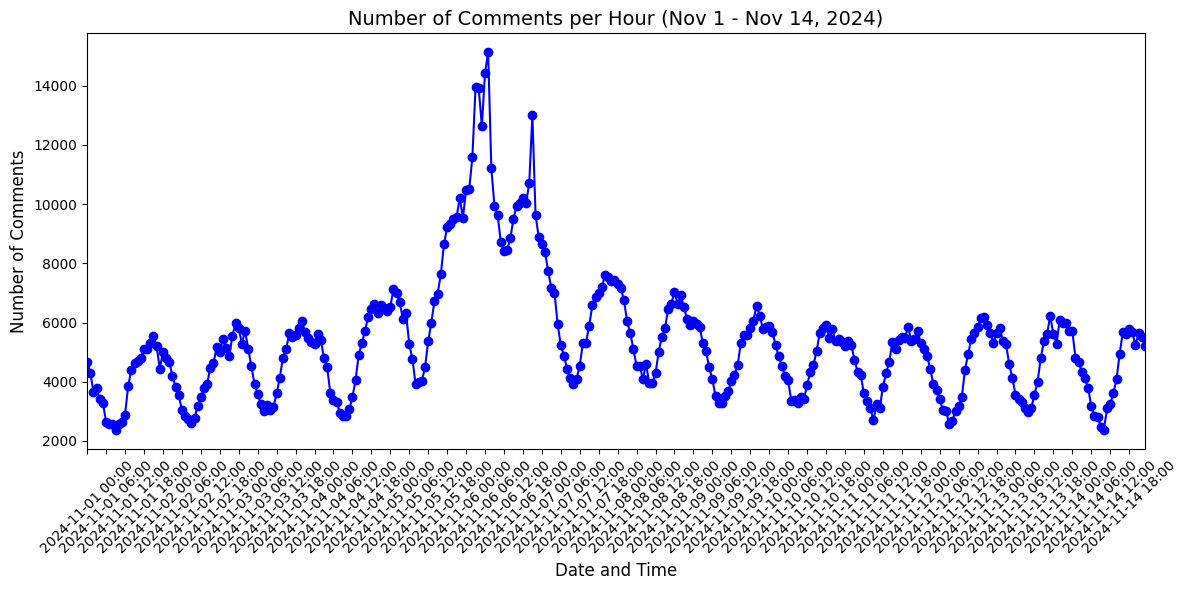

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_file = '/content/New_ChanTest.csv'
df_filtered = pd.read_csv(filtered_file)

df_filtered['time_datetime'] = pd.to_datetime(df_filtered['time_datetime'], errors='coerce')

invalid_dates = df_filtered['time_datetime'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} rows in 'time_datetime' could not be parsed and were excluded.")

df_filtered = df_filtered.dropna(subset=['time_datetime'])

df_filtered.set_index('time_datetime', inplace=True)

comment_per_hour = df_filtered.resample('1H').size()

plt.figure(figsize=(12, 6))
comment_per_hour.plot(kind='line', marker='o', linestyle='-', color='b')

plt.title('Number of Comments per Hour (Nov 1 - Nov 14, 2024)', fontsize=14)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)

plt.xticks(ticks=comment_per_hour.index[::6], labels=comment_per_hour.index[::6].strftime('%Y-%m-%d %H:%M'), rotation=45)

plt.tight_layout()
plt.show()
